# compute and plot the briged channels

In [ ]:
import sys
import os
import numpy as np
import mne
import matplotlib.pyplot as plt
import pickle
from collections import defaultdict
mne.set_log_level('WARNING') # Set MNE log level to WARNING to reduce verbosity
from preprocess import preprocess
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))# Add the parent directory to the path
from config import data_dir
# dir for save figures
plot_dir = os.path.join(os.path.join(os.getcwd(), ".."), 'plots', 'bridged')

old_adults_ids = np.arange(601, 619)
young_adults_ids = [303, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 319]
all_ids = np.concatenate((old_adults_ids, young_adults_ids))

all_bridged_channels = {}
for subject in all_ids:
    sub = preprocess(data_dir, subject)
    raw = sub.load_data()
    epochs = sub.epoching(raw)
    bridged_idx, ed_matrix, bridged_ch_names = sub.bridged_channels(epochs,   lm_cutoff = 5, epoch_threshold=0.5)
    all_bridged_channels[subject] = {'bridged_idx': bridged_idx, 'bridged_ch_names': bridged_ch_names}
    fig = mne.viz.plot_bridged_electrodes(raw.info,bridged_idx, ed_matrix, title=f"Subject {subject} Bridged Electrodes",topomap_args=dict(vlim=(None, 5)))
    fig.savefig(os.path.join(plot_dir, f"subject_{subject}_bridged_electrodes.png"), dpi=300, bbox_inches='tight')
    plt.close(fig)  
# Save the updated bridged channels data
with open(os.path.join(data_dir, 'bridged_channels_analysis.pkl'), "wb") as f:
    pickle.dump(all_bridged_channels, f)


# plots

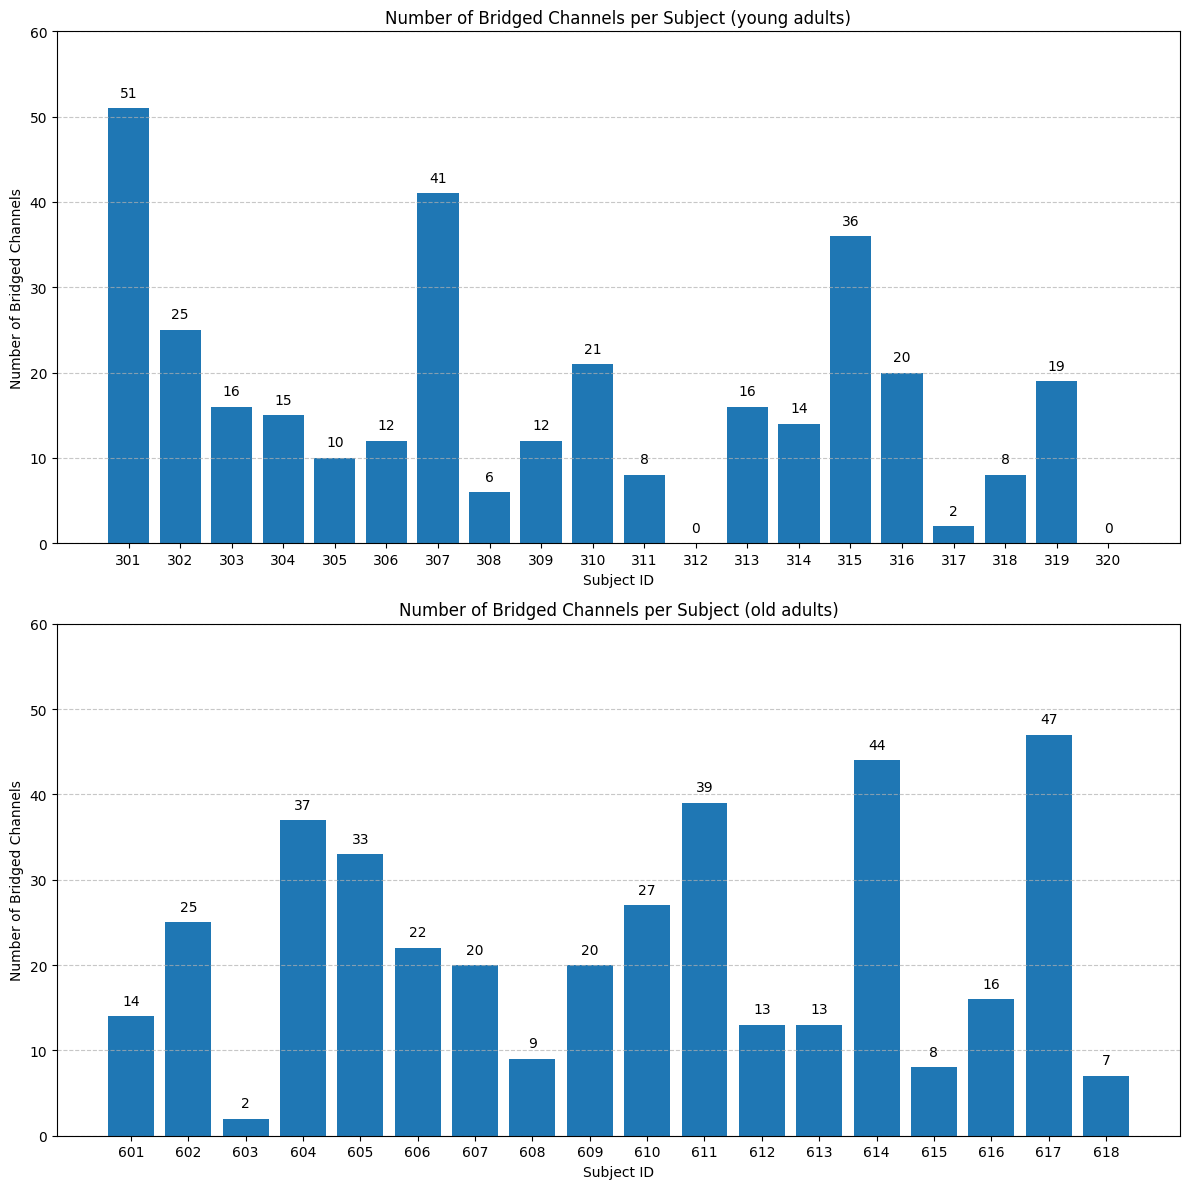

In [ ]:
# Visualization of results for both groups in one figure with two subplots (rows)
fig, axs = plt.subplots(2, 1, figsize=(12, 12), sharex=False)

# Young adults
young_ids = np.array([id for id in range(301, 321)])
young_counts = [len(all_bridged_channels.get(id, {"bridged_ch_names": []})["bridged_ch_names"]) for id in young_ids]
axs[0].bar(young_ids, young_counts)
axs[0].set_xlabel('Subject ID')
axs[0].set_ylabel('Number of Bridged Channels')
axs[0].set_ylim(0, 60)
axs[0].set_title('Number of Bridged Channels per Subject (young adults)')
axs[0].set_xticks(young_ids)
axs[0].grid(axis='y', linestyle='--', alpha=0.7)
for x, y in zip(young_ids, young_counts):
    axs[0].text(x, y + 1, str(y), ha='center', va='bottom', fontsize=10)

# Older adults
old_ids = np.array([id for id in range(601, 619)])
old_counts = [len(all_bridged_channels.get(id, {"bridged_ch_names": []})["bridged_ch_names"]) for id in old_ids]
axs[1].bar(old_ids, old_counts)
axs[1].set_xlabel('Subject ID')
axs[1].set_ylabel('Number of Bridged Channels')
axs[1].set_ylim(0, 60)
axs[1].set_title('Number of Bridged Channels per Subject (old adults)')
axs[1].set_xticks(old_ids)
axs[1].grid(axis='y', linestyle='--', alpha=0.7)
for x, y in zip(old_ids, old_counts):
    axs[1].text(x, y + 1, str(y), ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig(os.path.join(plot_dir, "bridged_channels_comparison.png"))
plt.show()


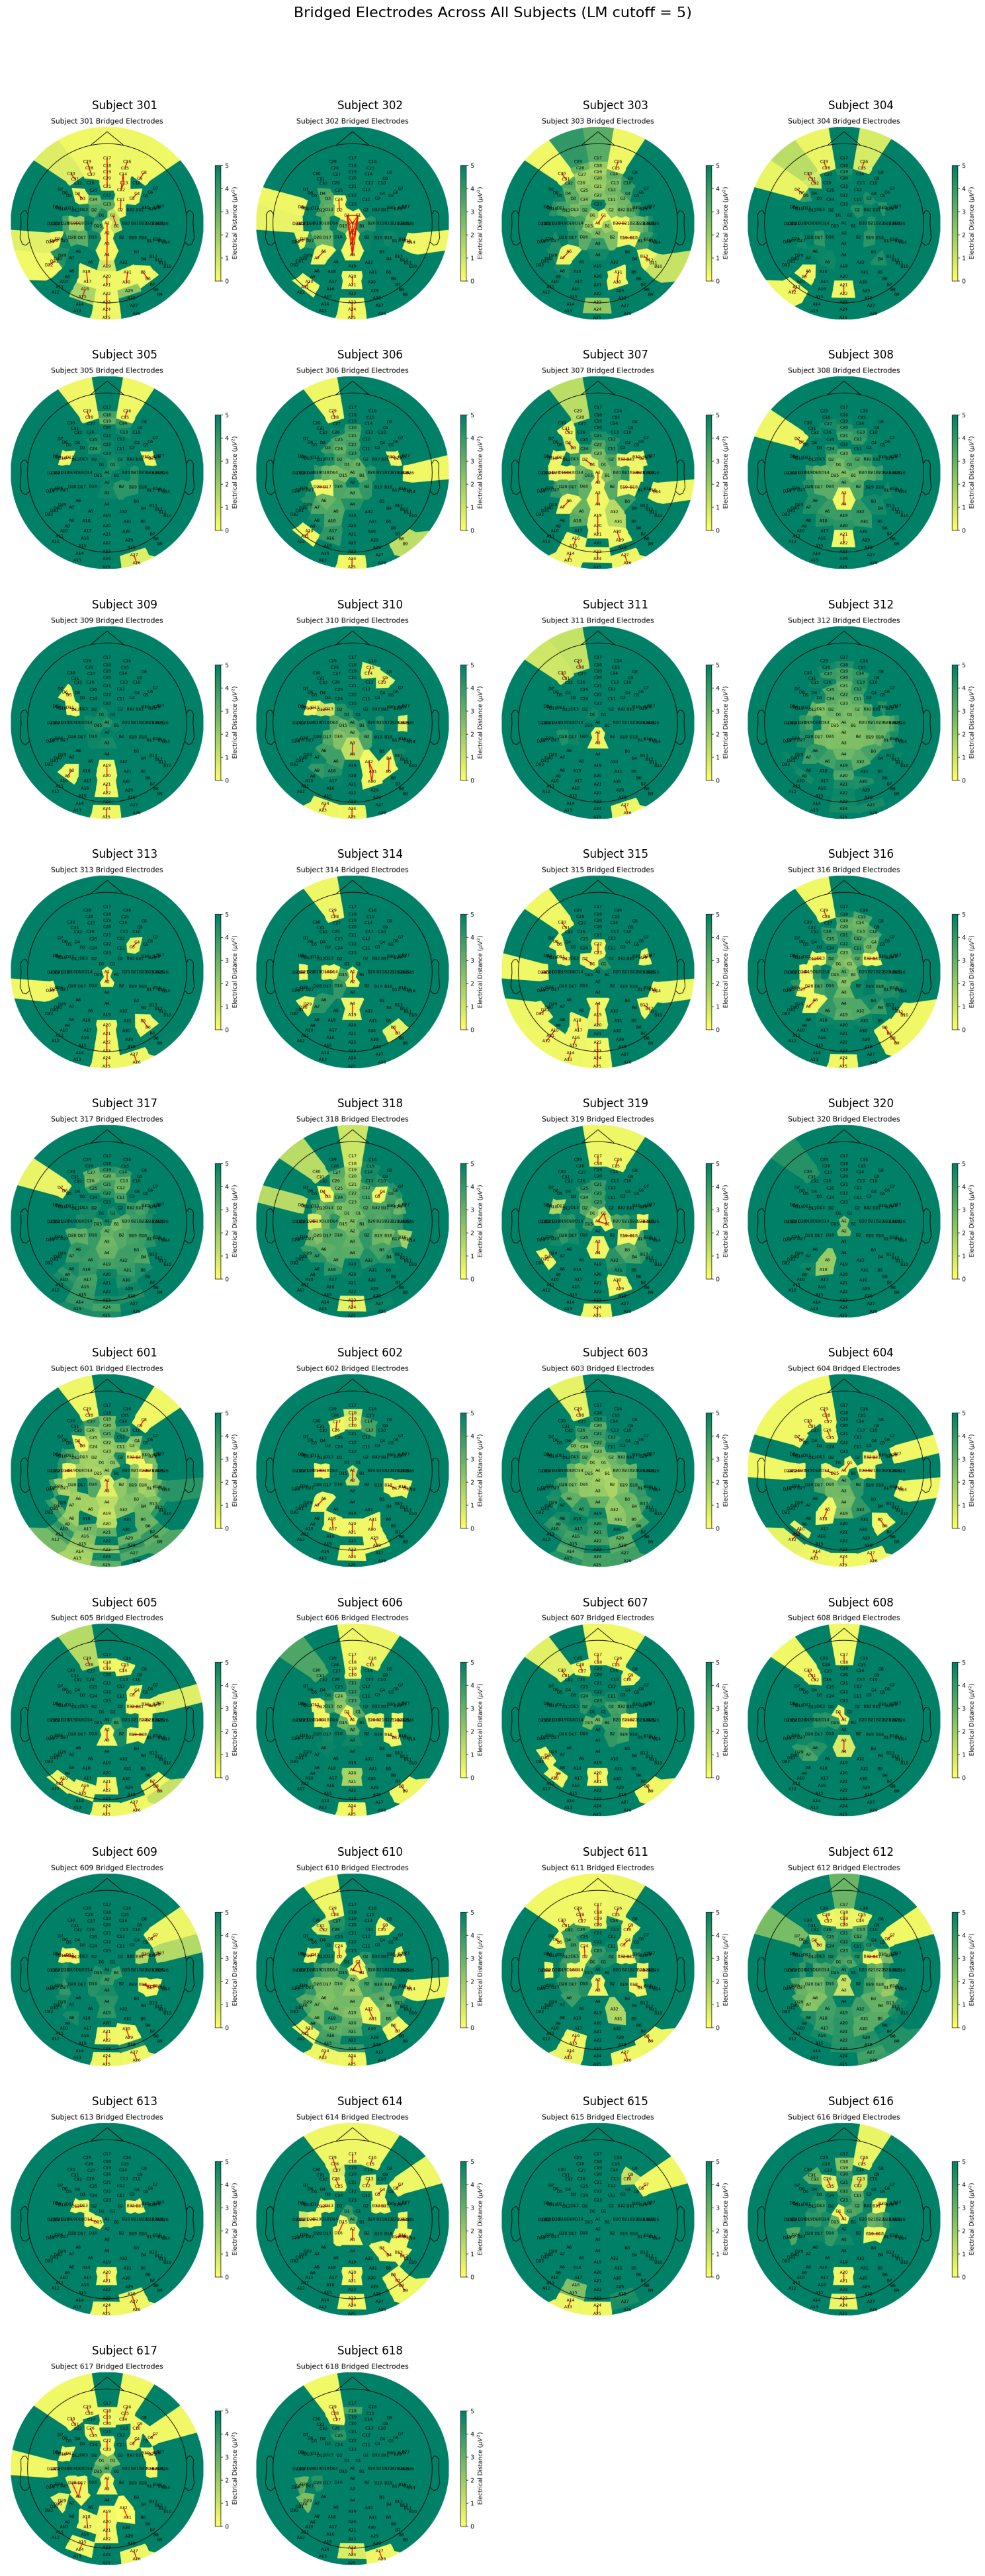

In [ ]:
import matplotlib.pyplot as plt
import os
import numpy as np
from PIL import Image


# Get all subject image files
subject_files = sorted([f for f in os.listdir(plot_dir) 
                       if f.startswith("subject_") and f.endswith("_bridged_electrodes.png")])

# Calculate grid dimensions
n_images = len(subject_files)
n_cols = 4  # Adjust based on how many columns you want
n_rows = int(np.ceil(n_images / n_cols))

# Create a figure with subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4*n_rows))
fig.suptitle("Bridged Electrodes Across All Subjects (LM cutoff = 5)", fontsize=16)

# If there's only one row, ensure axes is 2D
if n_rows == 1:
    axes = axes.reshape(1, -1)

# Plot each image
for i, img_file in enumerate(subject_files):
    # Calculate row and column indices
    row_idx = i // n_cols
    col_idx = i % n_cols
    
    # Extract subject ID from filename
    subject_id = img_file.split('_')[1]
    
    # Load image
    img_path = os.path.join(plot_dir, img_file)
    img = Image.open(img_path)
    
    # Plot image
    axes[row_idx, col_idx].imshow(np.array(img))
    axes[row_idx, col_idx].set_title(f"Subject {subject_id}")
    axes[row_idx, col_idx].axis('off')

# Turn off any empty subplots
for i in range(n_images, n_rows * n_cols):
    row_idx = i // n_cols
    col_idx = i % n_cols
    axes[row_idx, col_idx].axis('off')
    axes[row_idx, col_idx].set_visible(False)

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout, leaving room for suptitle
plt.savefig(os.path.join(plot_dir, "all_subjects_bridged_electrodes.png"), dpi=300, bbox_inches='tight')
plt.show()